# Initialisation

In [88]:
#Importing all the necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as TTS, KFold as K, cross_val_score as score  
from sklearn.linear_model import LinearRegression as LR 
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR 
from xgboost import XGBRegressor as XGR
import warnings
warnings.filterwarnings('ignore')

#Importing the datset
df = pd.read_csv(r'C:/Users/ADMIN/Downloads/flight_price.csv')

In [89]:
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [90]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [91]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [92]:
df.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662


# Data preprocessing

In [93]:
###################################################################################################################
#
#def preprocess(df):
# Input: main dataframe
#
# 1. Correct the datatypes
# 2. Generate new features
# 4. Drop previous features which are irrelevant now 
# 5. Standardise
# 6. return X, y
###################################################################################################################

def preprocess(df):

    #1. Correcting the datatypes    
    date_conv = lambda x: dt.strptime(str(x), '%d/%m/%Y')
    time_conv = lambda x: dt.strptime(str(x), '%H:%M')
    df['Date_of_Journey'] = df['Date_of_Journey'].apply(date_conv)

    #2. Generate new features
    hour = lambda x: x[x.index(":")-2:x.index(":")]
    minutes = lambda x: x[x.index(":")+1:x.index(":")+3]
    dur_hour = lambda x:x[:x.index("h")] if 'h' in x else 0
    dur_min = lambda x: x[x.index("m")-2:x.index("m")] if 'm' in x else 0
    stops = lambda x: 1 if '1' in str(x) else (2  if '2' in str(x) else(3 if '3' in str(x) else(4 if '4' in str(x) else (5 if '5' in str(x)else 0))))
    tod = lambda x: 'early morning' if 0<x<=6 else('morning' if 6<x<=12 else ('noon' if 12<x<=16 else ('evening' if 16<x<=20 else 'night')))

    df['Dep_hour'] = df.Dep_Time.apply(hour)
    df['Dep_minutes'] = df.Dep_Time.apply(minutes)
    df['Arr_hour'] = df.Arrival_Time.apply(hour)
    df['Arr_minutes'] = df.Arrival_Time.apply(minutes)
    df['Duration_hours'] = df.Duration.apply(dur_hour)
    df['Duration_mins'] = df.Duration.apply(dur_min)
    df.Duration_mins.replace({'':'0'},inplace=True)
    df['N_stops'] = df.Total_Stops.apply(stops)
    df.Dep_hour = df.Dep_hour.astype(int)
    df.Dep_minutes = df.Dep_minutes.astype(int)
    df.Arr_hour = df.Arr_hour.astype(int)
    df.Arr_minutes = df.Arr_minutes.astype(int)
    df.Duration_hours = df.Duration_hours.astype(int)
    df.Duration_mins = df.Duration_mins.astype(int)
    df.N_stops = df.N_stops.astype(int)

    X,y=df.drop(['Price'],axis=1), df.Price
    X.Additional_Info.replace({'No Info':'No info'}, inplace=True)
    X[['1 Long layover', '1 Short layover', '2 Long layover', 'Business class',
       'Change airports', 'In-flight meal not included',
       'No check-in baggage included', 'No info', 'Red-eye flight']]=pd.get_dummies(X.Additional_Info)
    X[['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways',
       'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy']]=pd.get_dummies(X.Airline)
    X[['Src_Banglore', 'Src_Chennai', 'Src_Delhi', 'Src_Kolkata',
        'Src_Mumbai']]=pd.get_dummies(X.Source, prefix="Src")
    X[['Dest_Banglore', 'Dest_Cochin', 'Dest_Delhi', 'Dest_Hyderabad',
       'Dest_Kolkata', 'Dest_New Delhi']]=pd.get_dummies(X.Destination, prefix="Dest")

    X['Day of month'] = X.Date_of_Journey.apply(lambda x: x.strftime("%d")).astype(int)
    X['Day of week'] = X.Date_of_Journey.apply(lambda x: x.strftime("%w")).astype(int)
    X['Month of year'] = X.Date_of_Journey.apply(lambda x: x.strftime("%m")).astype(int)
    X['Day of year'] = X.Date_of_Journey.apply(lambda x: x.timetuple().tm_yday)
    X['TOD of departure'] = X.Dep_hour.apply(tod)
    X['TOD of arrival'] = X.Arr_hour.apply(tod)

    X[['Dep_early morning', 'Dep_evening', 'Dep_morning', 'Dep_night', 'Dep_noon']] = pd.get_dummies(X['TOD of departure'])
    X[['Arr_early morning', 'Arr_evening', 'Arr_morning', 'Arr_night', 'Arr_noon']] = pd.get_dummies(X['TOD of arrival'])
    #4. Dropping previous and now irrelevant features
    
    X.drop(['Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops','Additional_Info','Airline','Source','Destination', 'Date_of_Journey','Route','TOD of departure','TOD of arrival'],axis=1, inplace=True)
    
    #5. Standardisation
    sc=StandardScaler()
    X = sc.fit_transform(X)

    #6. Return X, y
    return X,y

In [94]:
X,y=preprocess(df)

In [95]:
#pd.DataFrame(X).corr().style.background_gradient(cmap='Reds')

<AxesSubplot:xlabel='Price', ylabel='Density'>

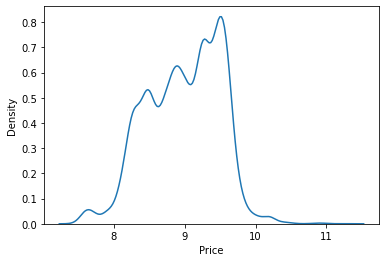

In [96]:
import seaborn as sns
y=np.log(y)
sns.kdeplot(y)

# Model

In [97]:
def models(model):

    folds=K(n_splits=5, shuffle=True, random_state=4)
    r=score(model,X,y,scoring='neg_mean_squared_error',cv=folds)
    scores = str(-round(r.mean(),2))+" ± "+str(round(r.std(),2))
#'neg_mean_absolute_error'
    return scores

In [98]:
#print("Absolute error for Linear Regression",models(LR()))
print("Absolute error for Decision tree regressor",models(DTR(max_depth=14)))    #Median best max_depth after 100 iterations of cross validation
print("Absolute error for Random forest regressor",models(RFR(max_depth=16)))
print("Absolute error for XGB Regressor",models(XGR(max_depth=5,eta=0.5, subsample=0.92)))

Absolute error for Decision tree regressor 0.02 ± 0.0
Absolute error for Random forest regressor 0.01 ± 0.0
Absolute error for XGB Regressor 0.02 ± 0.0


# Randomforest gives best result